In [1]:
import fastai
from fastai import *          # Quick access to most common functionality
from fastai.vision import *   # Quick access to computer vision functionality
from fastai.callbacks import *
from torchvision.models import vgg16_bn

In [2]:
PATH = Path('/DATA/kaggle/imgnetloc/ILSVRC/Data/CLS-LOC/')
PATH_TRN = PATH/'train'

sz_lr=72
scale,bs = 4,24
sz_hr = sz_lr*scale

In [3]:
classes = list(PATH_TRN.iterdir())
fnames_full = []
for class_folder in progress_bar(classes):
    for fname in class_folder.iterdir():
        fnames_full.append(fname)

np.random.seed(42)
keep_pct = 0.02
#keep_pct = 1.
keeps = np.random.rand(len(fnames_full)) < keep_pct
image_fns = np.array(fnames_full, copy=False)[keeps]
len(image_fns)

25584

In [4]:
# val_fn = [PATH_TRN/fn for fn in pd.read_csv('/home/fredmonroe/valid.csv')['fn_x']]
# train_fn = [PATH_TRN/fn for fn in pd.read_csv('/home/fredmonroe/train.csv')['fn_x']]
# src = (ImageToImageList(train_fn+val_fn)
#        .split_by_valid_func(lambda o: o in val_fn)
#        .label_from_func(lambda x: x))
# len(val_fn), len(train_fn)

valid_pct=0.1
src = (ImageToImageList(image_fns)
       .random_split_by_pct(valid_pct, seed=42)
       .label_from_func(lambda x: x))

In [5]:
def get_data(bs, sz_lr, sz_hr, num_workers=12, **kwargs):
#     tfms = get_transforms(do_flip=True, flip_vert=True,
#                             max_lighting=0.0, max_rotate=0.0,max_zoom=0.0,max_warp=0.0)
    
    tfms = [[dihedral_affine(p=0.75), crop_pad(row_pct=0.5, col_pct=0.5)],
            [crop_pad(row_pct=0.5, col_pct=0.5)]]
#    tfms = get_transforms(flip_vert=True)
    print(tfms[0])
    data = (src
            .transform(tfms, size=sz_lr)
            .transform_labels(size=sz_hr)
            .databunch(bs=bs, num_workers=num_workers, **kwargs)
            .normalize(imagenet_stats, do_y=True))
    return data

sz_lr = 72
scale,bs = 4,24
sz_hr = sz_lr*scale
data = get_data(bs, sz_lr, sz_hr)

[RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=0.75, resolved={}, do_run=True, is_random=True), RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': 0.5, 'col_pct': 0.5}, p=1.0, resolved={}, do_run=True, is_random=True)]


In [6]:
data.train_ds[0:3]

LabelList
y: ImageItemList (3 items)
[Image (3, 393, 500), Image (3, 533, 700), Image (3, 375, 500)]...
Path: .
x: ImageToImageList (3 items)
[Image (3, 393, 500), Image (3, 533, 700), Image (3, 375, 500)]...
Path: .

In [7]:
x,y = data.dl().one_batch()
x.shape, y.shape

(torch.Size([36, 3, 72, 72]), torch.Size([36, 3, 288, 288]))

(None, None)

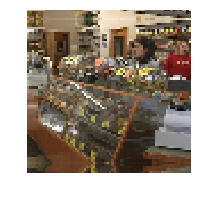

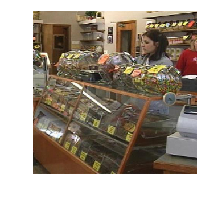

In [8]:
def make_img(x, idx=0):
    return Image(torch.clamp(data.denorm(x.cpu()),0,1)[idx])

idx=3
x_img = make_img(x, idx)
y_img = make_img(y, idx)
x_img.show(), y_img.show()

#Model

In [9]:
def conv(ni, nf, kernel_size=3, actn=True):
    layers = [nn.Conv2d(ni, nf, kernel_size, padding=kernel_size//2)]
    if actn: layers.append(nn.ReLU(True))
    return nn.Sequential(*layers)

In [10]:
class ResSequential(nn.Module):
    def __init__(self, layers, res_scale=1.0):
        super().__init__()
        self.res_scale = res_scale
        self.m = nn.Sequential(*layers)

    def forward(self, x):
        x = x + self.m(x) * self.res_scale
        return x

In [11]:
def res_block(nf):
    return ResSequential(
        [conv(nf, nf), conv(nf, nf, actn=False)],
        0.1)

In [12]:
def upsample(ni, nf, scale):
    layers = []
    for i in range(int(math.log(scale,2))):
        layers += [conv(ni, nf*4), nn.PixelShuffle(2)]
    return nn.Sequential(*layers)


In [13]:
class SrResnet(nn.Module):
    def __init__(self, nf, scale, n_res=8):
        super().__init__()
        features = [conv(3, 64)]
        for i in range(n_res): features.append(res_block(64))
        features += [conv(64,64), upsample(64, 64, scale),
                     nn.BatchNorm2d(64),
                     conv(64, 3, actn=False)]
        self.features = nn.Sequential(*features)
        
    def forward(self, x): return self.features(x)

In [14]:
def icnr(x, scale, init=nn.init.kaiming_normal_):
    new_shape = [int(x.shape[0] / (scale ** 2))] + list(x.shape[1:])
    subkernel = torch.zeros(new_shape)
    subkernel = init(subkernel)
    subkernel = subkernel.transpose(0, 1)
    subkernel = subkernel.contiguous().view(subkernel.shape[0],
                                            subkernel.shape[1], -1)
    kernel = subkernel.repeat(1, 1, scale ** 2)
    transposed_shape = [x.shape[1]] + [x.shape[0]] + list(x.shape[2:])
    kernel = kernel.contiguous().view(transposed_shape)
    kernel = kernel.transpose(0, 1)
    return kernel

In [15]:
model = SrResnet(64, scale)

In [16]:
#model = torch.load('old.pth')

In [20]:
# wd=1e-7
# learn = Learner(data, nn.DataParallel(model,[0,2]), loss_func=F.mse_loss, opt_func=torch.optim.Adam, wd=wd, true_wd=False)

sz_lr = 72
scale,bs = 4,8
sz_hr = sz_lr*scale
data = get_data(bs, sz_lr, sz_hr)

learn = Learner(data, nn.DataParallel(model), loss_func=F.mse_loss)

[RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=0.75, resolved={}, do_run=True, is_random=True), RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': 0.5, 'col_pct': 0.5}, p=1.0, resolved={}, do_run=True, is_random=True)]


In [ ]:
learn.lr_find()
learn.recorder.plot()

In [18]:
lr = 1e-3
learn.fit_one_cycle(1, lr)

Total time: 20:12
epoch  train_loss  valid_loss
1      0.203613    0.027618    (20:12)



In [ ]:
lr = 2e-3
learn.fit_one_cycle(1, lr/10)

In [ ]:
#learn.fit_one_cycle(5, lr/5, wd=wd)
imagenet_stats, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

In [19]:
learn.save('pixel')

In [21]:
learn = learn.load('pixel')

In [26]:
def plot_x_y_pred(x, pred, y, figsize):
    rows=x.shape[0]
    fig, axs = plt.subplots(rows,3,figsize=figsize)
    for i in range(rows):
        make_img(x, i).show(ax=axs[i, 0])
        make_img(pred, i).show(ax=axs[i, 1])
        make_img(y, i).show(ax=axs[i, 2])
    plt.tight_layout()    

In [23]:
x, y = next(iter(learn.data.valid_dl))
y_pred = model(x)
x[0:3].shape

torch.Size([3, 3, 72, 72])

(None, None)

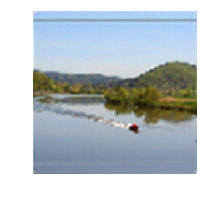

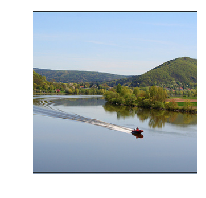

In [25]:
make_img(y_pred.detach(), 2).show(), make_img(y.detach(), 2).show()

In [28]:
def plot_some(learn, do_denorm=True):
    x, y = next(iter(learn.data.valid_dl))
    y_pred = model(x)
    y_pred = y_pred.detach()
    x = x.detach()
    y = y.detach()
    plot_x_y_pred(x[0:3], y_pred[0:3], y[0:3], figsize=y_pred.shape[-2:])

In [29]:
plot_some(learn)

In [30]:
m_vgg_feat = vgg16_bn(True).cuda().eval().features
requires_grad(m_vgg_feat, False)

blocks = [i-1 for i,o in enumerate(children(m_vgg_feat))
              if isinstance(o,nn.MaxPool2d)]
blocks, [m_vgg_feat[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [31]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metrics = {}
        self.metric_names = [f'feat_{i}' for i in range(len(layer_ids))]
        for name in self.metric_names: self.metrics[name] = 0.

    def make_feature(self, bs, o, clone=False):
        feat = o.view(bs, -1)
        if clone: feat = feat.clone()
        return feat
    
    def make_features(self, x, clone=False):
        bs = x.shape[0]
        self.m_feat(x)
        return [self.make_feature(bs, o, clone) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [F.mse_loss(f_in, f_out)*w
                            for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        for i,name in enumerate(self.metric_names): self.metrics[name] = self.feat_losses[i]
        self.loss = sum(self.feat_losses)
        return self.loss
        
class ReportLossMetrics(LearnerCallback):
    _order = -20 #Needs to run before the recorder
        
    def on_train_begin(self, **kwargs):
        self.metric_names = self.learn.loss_func.metric_names
        self.learn.recorder.add_metric_names(self.metric_names)
    
    def on_epoch_begin(self, **kwargs):
        self.metrics = {}
        for name in self.metric_names:
            self.metrics[name] = 0.
        self.nums = 0
    
    def on_batch_end(self, last_target, train, **kwargs):
        if not train:
            bs = last_target.size(0)
            for name in self.metric_names:
                self.metrics[name] += bs * self.learn.loss_func.metrics[name]
            self.nums += bs
    
    def on_epoch_end(self, **kwargs):
        metrics = [self.metrics[name]/self.nums for name in self.metric_names]
        self.learn.recorder.add_metrics(metrics)


In [32]:
model = SrResnet(64, scale)

In [33]:
nres = 8
conv_shuffle = model.features[nres+2][0][0]
kernel = icnr(conv_shuffle.weight, scale=scale)
conv_shuffle.weight.data.copy_(kernel);

conv_shuffle = model.features[nres+2][2][0]
kernel = icnr(conv_shuffle.weight, scale=scale)
conv_shuffle.weight.data.copy_(kernel);

In [34]:
sz_lr = 72
scale,bs = 4,24
sz_hr = sz_lr*scale

data = get_data(bs, sz_lr, sz_hr)

feat_loss = FeatureLoss(m_vgg_feat, blocks[:2], [0.26,0.74])

learn = Learner(data, nn.DataParallel(model), loss_func=feat_loss, callback_fns=[ReportLossMetrics])

[RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=0.75, resolved={}, do_run=True, is_random=True), RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': 0.5, 'col_pct': 0.5}, p=1.0, resolved={}, do_run=True, is_random=True)]


In [35]:
learn.freeze_to(999)
for i in range(10,13): requires_grad(model.features[i], True)

In [ ]:
learn.load('pixel')
learn.lr_find()
learn.recorder.plot()

In [36]:
lr=6e-3
wd=1e-7

learn.fit_one_cycle(1, lr, wd=wd)

Total time: 11:24
epoch  train_loss  valid_loss  feat_0  feat_1    
1      0.026575    0.026168    0.007635  0.018533  (11:24)



In [37]:
learn.save('enhance_feat')

In [38]:
learn = learn.load('enhance_feat')

In [ ]:
plot_some(learn)